This notebooks is produced by:

- [Network Analysis Made Simple](https://ericmjl.github.io/Network-Analysis-Made-Simple/) by [Eric Ma](https://github.com/ericmjl) and [Mridul Seth](https://github.com/MridulS).


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction to Hubs

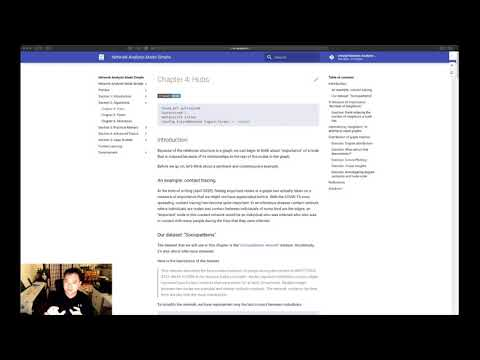

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="-oimHbVDdDA", width=560, height=315)

Because of the relational structure in a graph,
we can begin to think about "importance" of a node
that is induced because of its relationships
to the rest of the nodes in the graph.

Before we go on, let's think about
a pertinent and contemporary example.

### An example: contact tracing

At the time of writing (April 2020),
finding important nodes in a graph has actually taken on a measure of importance
that we might not have appreciated before.
With the COVID-19 virus spreading,
contact tracing has become quite important.
In an infectious disease contact network,
where individuals are nodes and
contact between individuals of some kind are the edges,
an "important" node in this contact network
would be an individual who was infected
who also was in contact with many people
during the time that they were infected.

### Our dataset: "Sociopatterns"

The dataset that we will use in this chapter is the "[sociopatterns network][sociopatterns]" dataset.
Incidentally, it's also about infectious diseases. 

[sociopatterns]: http://www.sociopatterns.org/datasets/infectious-sociopatterns-dynamic-contact-networks/

Note to readers: We originally obtained the dataset in 2014
from the Konect website.
It is unfortunately no longer available.
The sociopatterns.org website hosts an edge list of a slightly different format,
so it will look different from what we have here.

From the original description on Konect, here is the description of the dataset:

> This network describes the face-to-face behavior of people
> during the exhibition INFECTIOUS: STAY AWAY in 2009
> at the Science Gallery in Dublin.
> Nodes represent exhibition visitors;
> edges represent face-to-face contacts that were active for at least 20 seconds.
> Multiple edges between two nodes are possible and denote multiple contacts.
> The network contains the data from the day with the most interactions.

To simplify the network, we have represented only the last contact between individuals.

[README - Details of sociopatterns-infectious](https://github.com/ericmjl/Network-Analysis-Made-Simple/blob/master/data/sociopatterns-infectious/README.sociopatterns-infectious)

In [ ]:
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

df = pd.read_csv(
        "https://raw.githubusercontent.com/ericmjl/Network-Analysis-Made-Simple/master/data/sociopatterns-infectious/out.sociopatterns-infectious",
        sep=" ",
        skiprows=2,
        header=None,
    )
df = df[[0, 1, 2]]
df.columns = ["person1", "person2", "weight"]

G = nx.Graph()
for row in df.iterrows():
    p1 = row[1]["person1"]
    p2 = row[1]["person2"]
    if G.has_edge(p1, p2):
        G.edges[p1, p2]["weight"] += 1
    else:
        G.add_edge(p1, p2, weight=1)

for n in sorted(G.nodes()):
    G.nodes[n]["order"] = float(n)



It is loaded as an undirected graph object:

In [ ]:
type(G)

networkx.classes.graph.Graph

As usual, before proceeding with any analysis,
we should know basic graph statistics.

In [ ]:
len(G.nodes()), len(G.edges())

(410, 2765)

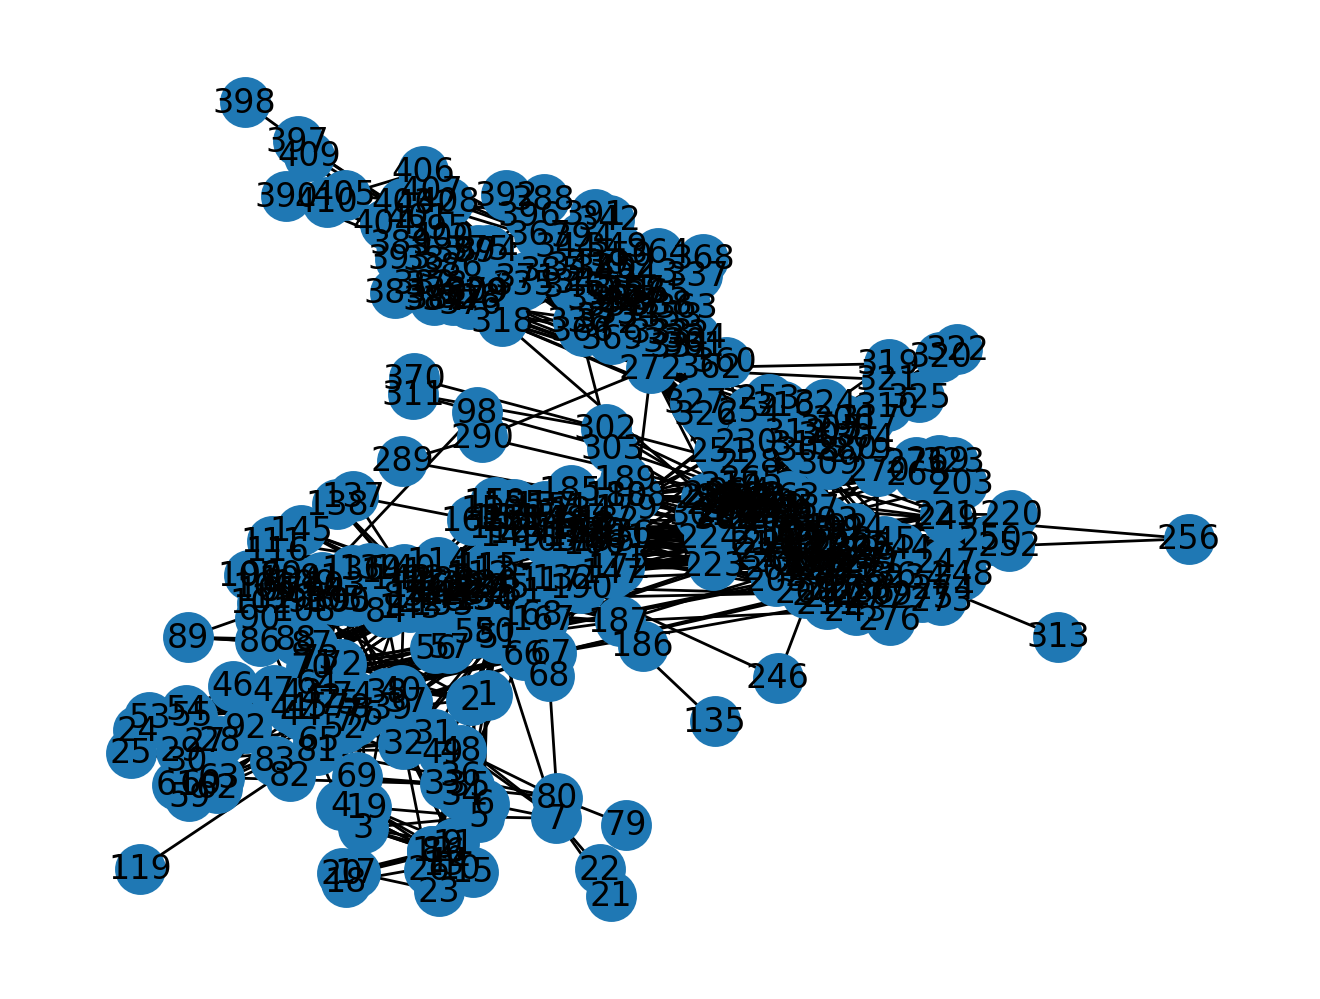

In [ ]:
nx.draw(G, with_labels=True)
plt.show()

## A Measure of Importance: "Number of Neighbors"

One measure of importance of a node is
the number of **neighbors** that the node has.
What is a **neighbor**?
We will work with the following definition:

> The neighbor of a node is connected to that node by an edge.

Let's explore this concept, using the NetworkX API.

Every NetworkX graph provides a `G.neighbors(node)` class method,
which lets us query a graph for the number of neighbors
of a given node:

In [ ]:
G.neighbors(7)

It returns a generator that doesn't immediately return
the exact neighbors list.
This means we cannot know its exact length,
as it is a generator.
If you tried to do:

```python
len(G.neighbors(7))
```

you would get the following error:

```python
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-13-72c56971d077> in <module>
----> 1 len(G.neighbors(7))

TypeError: object of type 'dict_keyiterator' has no len()
```

Hence, we will need to cast it as a list in order to know
both its length
and its members:

In [ ]:
list(G.neighbors(7))

[5, 6, 21, 22, 37, 48, 51]

In the event that some nodes have an extensive list of neighbors,
then using the `dict_keyiterator` is potentially a good memory-saving technique,
as it lazily yields the neighbors.

### Exercise: Rank-ordering the number of neighbors a node has

Since we know how to get the list of nodes that are neighbors of a given node,
try this following exercise:

> Can you create a ranked list of the importance of each individual, based on the number of neighbors they have?

Here are a few hints to help:

- You could consider using a `pandas Series`. This would be a modern and idiomatic way of approaching the problem.
- You could also consider using Python's `sorted` function.

In [ ]:
#### REPLACE THE NEXT FEW LINES WITH YOUR ANSWER


In [ ]:
#@title
def rank_ordered_neighbors(G):
    """
    Uses a pandas Series to help with sorting.
    """
    s = pd.Series({n: len(list(G.neighbors(n))) for n in G.nodes()})
    return s.sort_values(ascending=False)

The original implementation looked like the following

In [ ]:
#@title
def rank_ordered_neighbors_original(G):
    """Original implementation of rank-ordered number of neighbors."""
    return sorted(G.nodes(), key=lambda x: len(list(G.neighbors(x))), reverse=True)

## Generalizing "neighbors" to arbitrarily-sized graphs

The concept of neighbors is simple and appealing,
but it leaves us with a slight point of dissatisfaction:
it is difficult to compare graphs of different sizes.
Is a node more important solely because it has more neighbors?
What if it were situated in an extremely large graph?
Would we not expect it to have more neighbors?

As such, we need a normalization factor.
One reasonable one, in fact, is
_the number of nodes that a given node could **possibly** be connected to._
By taking the ratio of the number of neighbors a node has
to the number of neighbors it could possibly have,
we get the **degree centrality** metric.

Formally defined, the degree centrality of a node (let's call it $d$)
is the number of neighbors that a node has (let's call it $n$)
divided by the number of neighbors it could _possibly_ have (let's call it $N$):

$$d = \frac{n}{N}$$

NetworkX provides a function for us to calculate degree centrality conveniently:

In [ ]:
import networkx as nx
import pandas as pd
dcs = pd.Series(nx.degree_centrality(G))
dcs

100    0.070905
101    0.031785
102    0.039120
103    0.063570
104    0.041565
         ...   
89     0.009780
91     0.051345
96     0.036675
99     0.034230
98     0.002445
Length: 410, dtype: float64

`nx.degree_centrality(G)` returns to us a dictionary of key-value pairs,
where the keys are node IDs
and values are the degree centrality score.
To save on output length, I took the liberty of casting it as a pandas Series
to make it easier to display.

Incidentally, we can also sort the series
to find the nodes with the highest degree centralities:

In [ ]:
dcs.sort_values(ascending=False)

51     0.122249
272    0.114914
235    0.105134
195    0.105134
265    0.083130
         ...   
390    0.002445
135    0.002445
398    0.002445
186    0.002445
98     0.002445
Length: 410, dtype: float64

Does the list order look familiar?
It should, since the numerator of the degree centrality metric
is identical to the number of neighbors,
and the denominator is a constant.

## Distribution of graph metrics

One important concept that you should come to know
is that the distribution of node-centric values
can characterize classes of graphs.

What do we mean by "distribution of node-centric values"?
One would be the degree distribution,
that is, the collection of node degree values in a graph.

Generally, you might be familiar with plotting a histogram
to visualize distributions of values,
but in this book, we are going to avoid histograms like the plague.
I detail a lot of reasons in a [blog post][ecdf] I wrote in 2018,
but the main points are that:

1. It's easier to lie with histograms.
1. You get informative statistical information (median, IQR, extremes/outliers)
more easily.

[ecdf]: https://ericmjl.github.io/blog/2018/7/14/ecdfs/

### Exercise: Degree distribution

In this next exercise, we are going to get practice visualizing these values
using empirical cumulative distribution function plots.

I have written for you an ECDF function that you can use already.
Its API looks like the following:

```python
x, y = ecdf(list_of_values)
```

giving you `x` and `y` values that you can directly plot.

The exercise prompt is this:

> Plot the ECDF of the degree centrality and degree distributions.

First do it for **degree centrality**:

In [ ]:
#@title
def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

In [ ]:
#@title
def ecdf_degree_centrality(G):
    """ECDF of degree centrality."""
    x, y = ecdf(list(nx.degree_centrality(G).values()))
    plt.scatter(x, y)
    plt.xlabel("degree centrality")
    plt.ylabel("cumulative fraction")

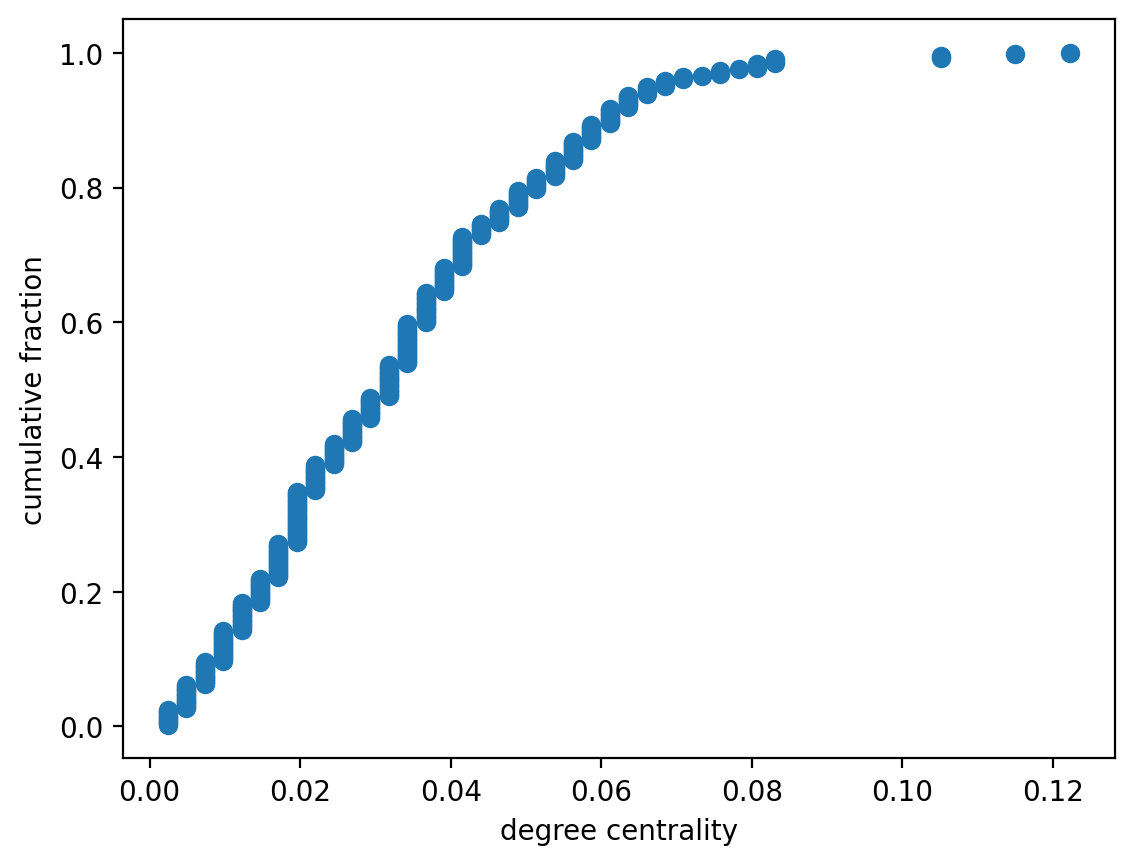

In [ ]:
ecdf_degree_centrality(G)

Now do it for **degree**:

In [ ]:
#### REPLACE THE FUNCTION CALL WITH YOUR ANSWER


In [ ]:
#@title
def ecdf_degree(G):
    """ECDF of degree."""
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")

The fact that they are identically-shaped
should not surprise you!

### Exercise: What about that denominator?

The denominator $N$ in the degree centrality definition
is "the number of nodes that a node could _possibly_ be connected to".
Can you think of two ways $N$ be defined?

In [ ]:
#### UNCOMMENT TO SEE MY ANSWER


In [ ]:
#@title
def num_possible_neighbors():
    """Answer to the number of possible neighbors for a node."""
    return r"""
The number of possible neighbors can either be defined as:

1. All other nodes but myself
2. All other nodes and myself

If $K$ is the number of nodes in the graph,
then if defined as (1), $N$ (the denominator) is $K - 1$.
If defined as (2), $N$ is equal to $K$.
"""

### Exercise: Circos Plotting

Let's get some practice with the `nxviz` API.

> Visualize the graph `G`, while ordering and colouring them by the 'order' node attribute.


[Using nxviz](https://pypi.org/project/nxviz/)

In [ ]:
#### REPLACE THE NEXT LINE WITH YOUR ANSWER


In [ ]:
!pip install nxviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


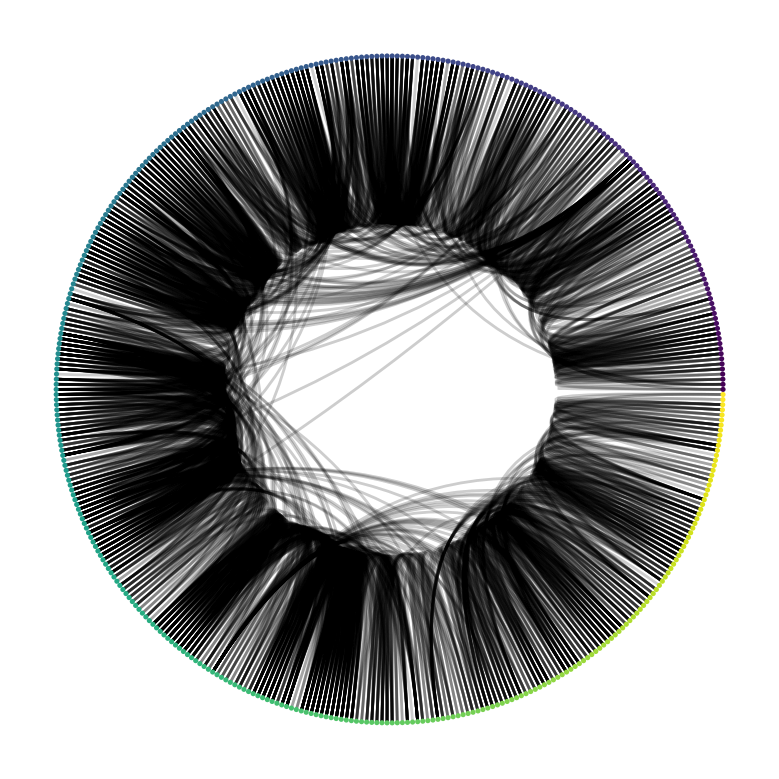

In [ ]:
import nxviz as nv

c = nv.CircosPlot(G, node_order="order", node_color="order")
# Draw the CircosPlot to the screen
c

In [ ]:
import nxviz as nv
from nxviz import annotate

#@title
def circos_plot(G):
    """Draw a Circos Plot of the graph."""
    # c = CircosPlot(G, node_order="order", node_color="order")
    # c.draw()
    nv.circos(G, sort_by="order", node_color_by="order")
    annotate.node_colormapping(G, color_by="order")

In [ ]:
#@title
circos_plot(G)

And here's an alternative view using an arc plot. 


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import nxviz as nv

nv.arc(G, sort_by="order", node_color_by="order")

### Exercise: Visual insights

Since we know that node colour and order
are by the "order" in which the person entered into the exhibit,
what does this visualization tell you?

In [ ]:
#@title
def visual_insights():
    """Visual insights from the Circos Plot."""
    return """
We see that most edges are "local" with nodes
that are proximal in order.
The nodes that are weird are the ones that have connections
with individuals much later than itself,
crossing larger jumps in order/time.

Additionally, if you recall the ranked list of degree centralities,
it appears that these nodes that have the highest degree centrality scores
are also the ones that have edges that cross the circos plot.
"""

In [ ]:
#### 


### Exercise: Investigating degree centrality and node order

One of the insights that we might have gleaned from visualizing the graph
is that the nodes that have a high degree centrality
might also be responsible for the edges that criss-cross the Circos plot.
To test this, plot the following:

- x-axis: node degree centrality
- y-axis: maximum difference between the neighbors' `order`s (a node attribute) and the node's `order`.

In [ ]:
#@title
def dc_node_order(G):
    """Comparison of degree centrality by maximum difference in node order."""
    import matplotlib.pyplot as plt
    import pandas as pd
    import networkx as nx

    # Degree centralities
    dcs = pd.Series(nx.degree_centrality(G))

    # Maximum node order difference
    maxdiffs = dict()
    for n, d in G.nodes(data=True):
        diffs = []
        for nbr in G.neighbors(n):
            diffs.append(abs(G.nodes[nbr]["order"] - d["order"]))
        maxdiffs[n] = max(diffs)
    maxdiffs = pd.Series(maxdiffs)

    ax = pd.DataFrame(dict(degree_centrality=dcs, max_diff=maxdiffs)).plot(
        x="degree_centrality", y="max_diff", kind="scatter"
    )

The somewhat positive correlation between the degree centrality might tell us that this trend holds true.
A further applied question would be to ask what behaviour of these nodes would give rise to this pattern.
Are these nodes actually exhibit staff?
Or is there some other reason why they are staying so long?
This, of course, would require joining in further information
that we would overlay on top of the graph
(by adding them as node or edge attributes)
before we might make further statements.

## Centrality Measures

In [ ]:
%pylab inline
import networkx as nx
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [25]:
layout_dict = dict()

def draw_network_plot(graph, color_dict=None):
    global layout_dict
    
    if graph.name not in layout_dict:
        layout_dict[graph.name] = nx.spring_layout(graph)
        
    layout = layout_dict[graph.name]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    nx.draw_networkx(graph, ax=ax, node_color=color_dict, pos=layout)
    
    
as_series = lambda x: pd.Series(dict(x)).sort_values(ascending=False)

## The Data

Quick. Forget *everything* you know about Renaissance Italy.

Okay cool. Now, let's take a look at a few of the major families.

**Note**: For simplicity this data model doesn't burden us with keeping all family *members* straight. Similarly, all of the edges represent *symmetric* relationships from family to family (e.g. marriage, pact, etc) and doesn't allow for such realistic, *directioned* relationships as "owes money to," "insulted," or anything of that nature.

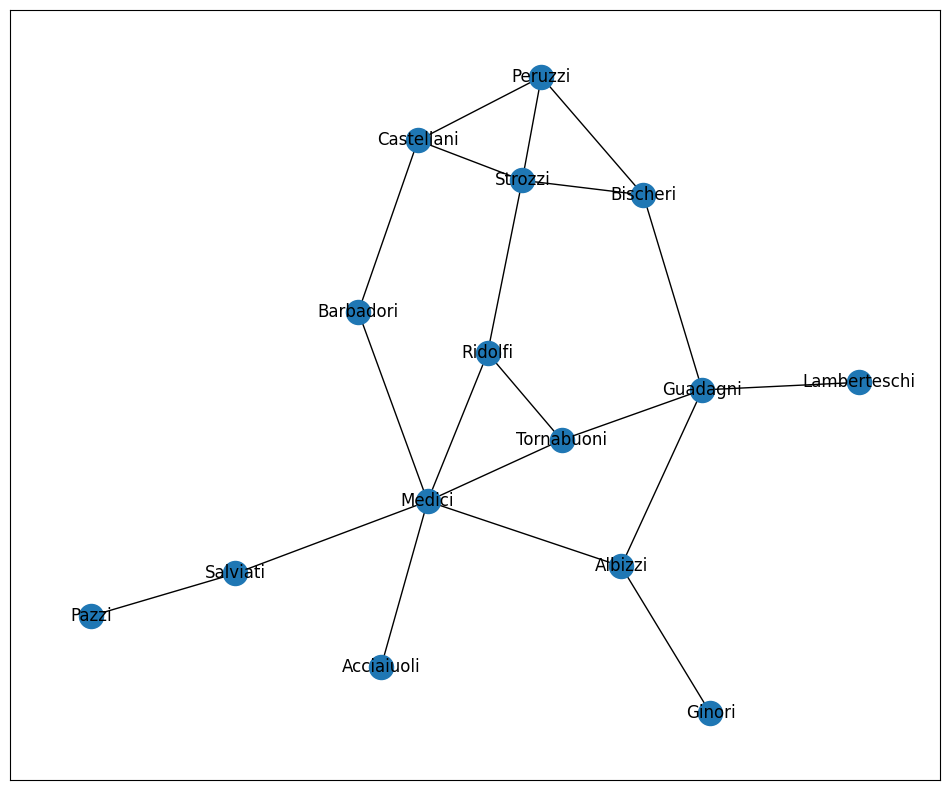

In [26]:
G = nx.florentine_families_graph()
G.name = 'florentine'

draw_network_plot(G)

Looking at this, and considering the famous-ish-ness of the data, we might be inclined to ask: "which family is most powerful and why?"-- I'm sure 15th century Italy did.

In a graph context, we might consider "most powerful" as "most important." So how, then, do we determine a node's importance in a network?

## Various Centrality Measures

There's no one-size-fits-all measure of a node's centrality within a network. As such, I'm going to breeze through a few popular metrics and give a brief overview of their trade-offs.

### Degree Centrality

This is an easy one. And probably the most intuitive. "What percent of all other nodes is this node connected to?"

In [ ]:
dc = nx.degree_centrality(G)
dc = pd.Series(dc, name='degree')

dc.sort_values(ascending=False)

Medici          0.428571
Strozzi         0.285714
Guadagni        0.285714
Castellani      0.214286
Peruzzi         0.214286
Ridolfi         0.214286
Tornabuoni      0.214286
Albizzi         0.214286
Bischeri        0.214286
Barbadori       0.142857
Salviati        0.142857
Acciaiuoli      0.071429
Pazzi           0.071429
Ginori          0.071429
Lamberteschi    0.071429
Name: degree, dtype: float64

Here, the Medicis are the clear frontrunner, nearly twice the value of the second-most-central family.

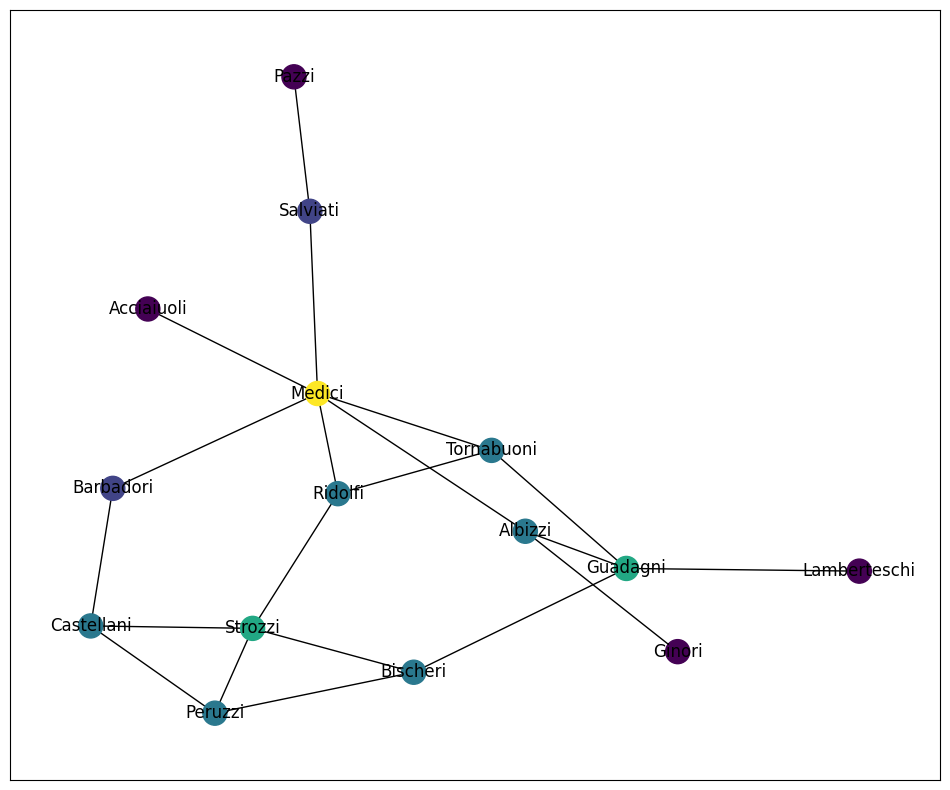

In [ ]:
draw_network_plot(G, dc)

In [ ]:
as_series(nx.degree(G))

Medici          6
Strozzi         4
Guadagni        4
Castellani      3
Peruzzi         3
Ridolfi         3
Tornabuoni      3
Albizzi         3
Bischeri        3
Barbadori       2
Salviati        2
Acciaiuoli      1
Pazzi           1
Ginori          1
Lamberteschi    1
dtype: int64

### Closeness Centrality

Closeness centrality measures "how close is this node to every other node" by taking, for each node,

```
1 / avg_dist_to_all_nodes
```

or 

In [ ]:
(
    1 / (
        sum(
            np.fromiter(
               (nx.shortest_path_length(G, 'Medici', other)
                for other in G.nodes
                if other != 'Medici'),
                dtype=np.float64
            )
       ) / (len(G.nodes) - 1)
   )
)

0.5599999999999999

this is wedged between two extremes:

* `0`: the node is disconnected from everything
* `1`: the node is a 'hub' and one step away from all other nodes in the network

In [ ]:
cc = nx.closeness_centrality(G)
cc = pd.Series(cc, name='closeness')

cc.sort_values(ascending=False)

Medici          0.560000
Ridolfi         0.500000
Tornabuoni      0.482759
Albizzi         0.482759
Guadagni        0.466667
Strozzi         0.437500
Barbadori       0.437500
Bischeri        0.400000
Castellani      0.388889
Salviati        0.388889
Acciaiuoli      0.368421
Peruzzi         0.368421
Ginori          0.333333
Lamberteschi    0.325581
Pazzi           0.285714
Name: closeness, dtype: float64

An even-er playing field.

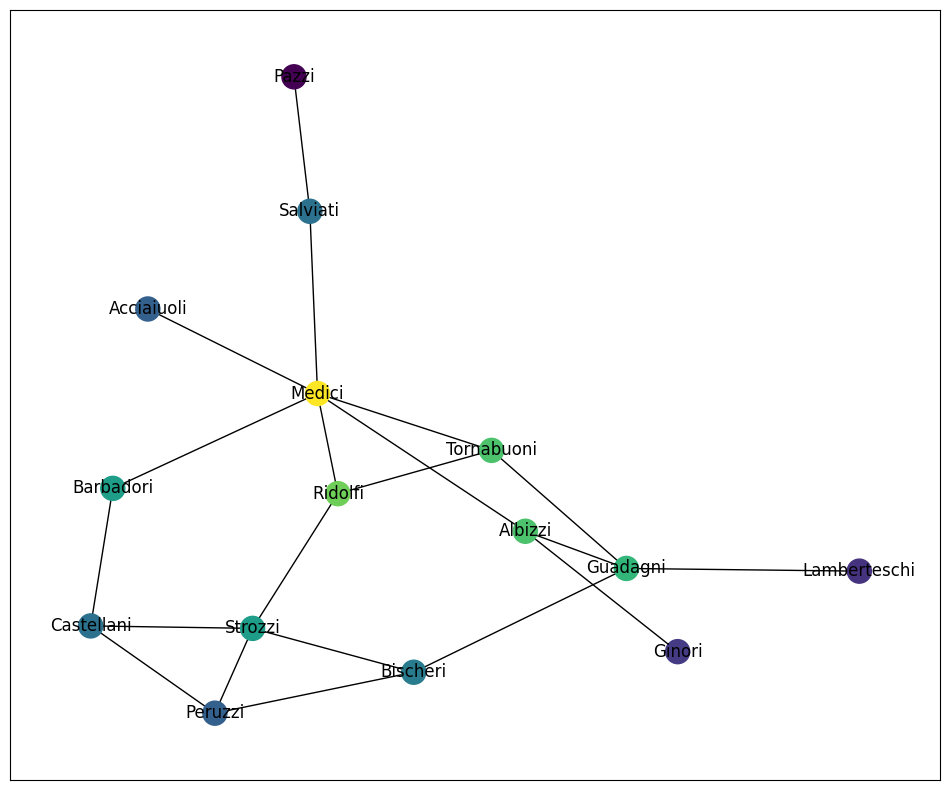

In [ ]:
draw_network_plot(G, cc)

This shouldn't come as a huge shock, however, as there isn't a TON of variation between max and min distance between any two nodes.

In [ ]:
nx.radius(G)

3

In [ ]:
nx.diameter(G)

5

In [ ]:
nx.eccentricity(G, 'Medici')

3

### Harmonic Centrality

This is VERY similar to Closeness Centrality. The key difference is where you're doing the averaging.

With Closeness Centrality, we averaged in the denominator. Here, we average the whole fraction, like so:

```
sum( 1 / (
          (dist(other) for other in nodes)
   ) / (n / 1)
```

or

In [ ]:
sum(
    1 /
    np.fromiter(
                (nx.shortest_path_length(G, 'Medici', other)
                    for other in G.nodes
                    if other != 'Medici'),
                dtype=np.float64)
   )

9.5

Unfortunately, `networkx` doesn't normalize the values like they do with Closeness Centrality.

In [ ]:
hc = nx.harmonic_centrality(G)
hc = pd.Series(hc, name='harmonic')

hc.sort_values(ascending=False)

Medici          9.500000
Guadagni        8.083333
Ridolfi         8.000000
Albizzi         7.833333
Tornabuoni      7.833333
Strozzi         7.833333
Bischeri        7.200000
Barbadori       7.083333
Castellani      6.916667
Peruzzi         6.783333
Salviati        6.583333
Acciaiuoli      5.916667
Lamberteschi    5.366667
Ginori          5.333333
Pazzi           4.766667
Name: harmonic, dtype: float64

For the sake of being able to compare Centrality measure to Centrality measure, we'll do that now

In [ ]:
hc = nx.harmonic_centrality(G)
hc = pd.Series(hc, name='harmoinic') / (len(hc) - 1)

hc.sort_values(ascending=False)

Medici          0.678571
Guadagni        0.577381
Ridolfi         0.571429
Albizzi         0.559524
Tornabuoni      0.559524
Strozzi         0.559524
Bischeri        0.514286
Barbadori       0.505952
Castellani      0.494048
Peruzzi         0.484524
Salviati        0.470238
Acciaiuoli      0.422619
Lamberteschi    0.383333
Ginori          0.380952
Pazzi           0.340476
Name: harmoinic, dtype: float64

At this point, you might find yourself jumping back and forth between this graph an the Closeness Centrality graph. I know I did, and I'm the one writing this damn notebook, lol

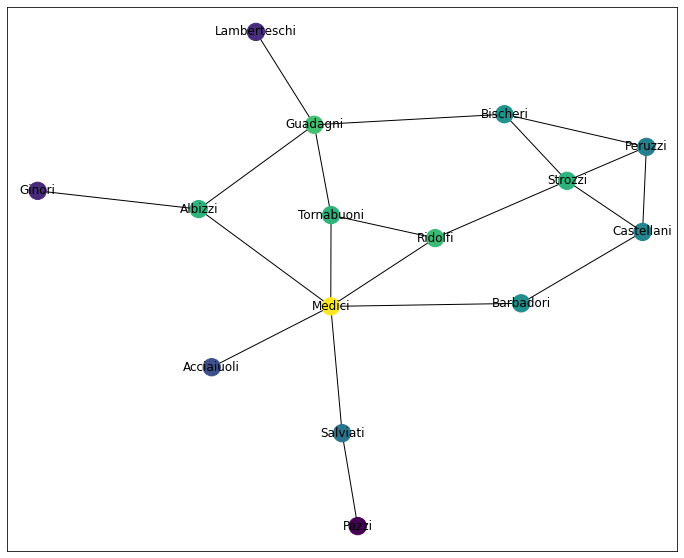

In [ ]:
draw_network_plot(G, hc)

Unfortunately, the book doesn't really expound on the difference between the two, merely offering

>When the closeness of a node is equal to 0 or 1, the harmonic closeness is also near 0 or 1. However, the two centralities in general differ and in the case of [the sample dataset the book had used to this point] are not even strongly correlated

Bummer.

Thankfully, a bit of poking around and [these Neo4j docs](https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/harmonic-centrality/) mention that the Harmonic Centrality was "invented to solve the problem the original formula had when dealing with unconnected graphs." And that's good enough for me :)

### Betweenness

Betweenness centrality is a really interesting one. It measures "the fraction of all possible geodesics that pass thorugh a node" and is essentially a measure of "how much is this node an essential go-between for any two given nodes?"

So we'll start by generating a list of all pairs in a Network

In [ ]:
from itertools import combinations

all_pairs = list(
    (a, b)
    for (a, b) in combinations(G.nodes, 2)
    if a != b
)

# dedupe ('medici', 'albizzi') vs ('albizzi', 'medici')
all_pairs = list(set(
    tuple(sorted((a, b))) for (a, b) in all_pairs
))

Then, we'll remove all mentions of `'Medici'`-- it doesn't make a ton of sense to consider the Medici family "between" themselves and another family, yeah?

In [ ]:
non_medici = [
    pair
    for pair in all_pairs
    if 'Medici' not in pair
]

len(non_medici)

91

This is good. We expect 91 pairs because in a graph of size

In [ ]:
len(G)

15

Subtracting 1 (`'Medici'`) and applying the "number of pairs" formula matches

In [ ]:
(14 * 13) / 2

91.0

And so basically, we want to calculate "of all shortest paths between any two nodes, how often is 'Medici' a part of that path?"

In [ ]:
sum(
    np.fromiter(
        ('Medici' in nx.shortest_path(G, node_a, node_b)
         for (node_a, node_b) in non_medici),
        dtype=np.float64
    )
) / len(non_medici)

0.5384615384615384

Finally, it's worth mentioning that this is an `O(n^2)` operation and thus scales pretty miserably, compared to the `O(n)`ish measures we've seen thus far.

Therefore our numbers are *a little* off, because `networkx` does some interesting sampling magic behind the scenes to make the computation tractable.

In [ ]:
bc = nx.betweenness_centrality(G, normalized=True)
bc = pd.Series(bc, name='betweenness')

bc.sort_values(ascending=False)

Medici          0.521978
Guadagni        0.254579
Albizzi         0.212454
Salviati        0.142857
Ridolfi         0.113553
Bischeri        0.104396
Strozzi         0.102564
Barbadori       0.093407
Tornabuoni      0.091575
Castellani      0.054945
Peruzzi         0.021978
Acciaiuoli      0.000000
Pazzi           0.000000
Ginori          0.000000
Lamberteschi    0.000000
Name: betweenness, dtype: float64

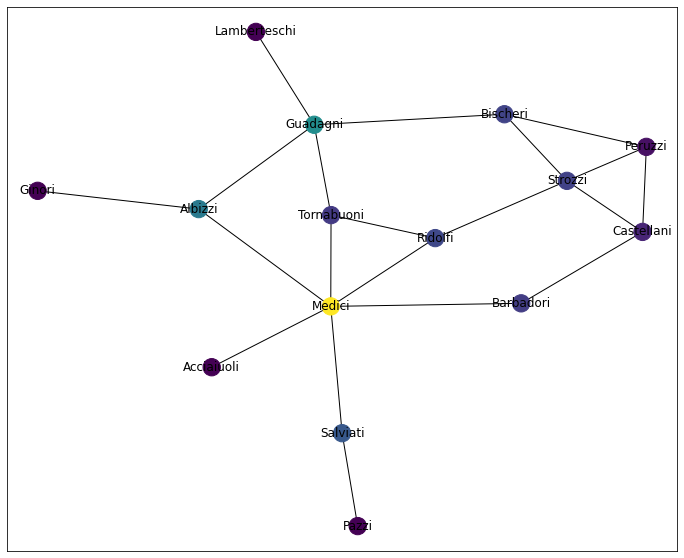

In [ ]:
draw_network_plot(G, bc)

### Eigen(vector) Centrality

Jury's still out on the specific *interpretation* of this measure ([link to unanswered GitHub question, at the time of writing](https://github.com/networkx/networkx/issues/4650)), but the *general idea* is reasonably-simple to follow:

* Eigenvector Centrality starts off randomly-instantiated, then is *recursively generated* from the network
* For a given node, connections to high-Eigenvector Centrality contribute more to the node's score than low-scoring nodes

Or as the author of the books puts it

> "Tell me who your friends are and I'll tell you who *you* are"

Which seems to apply some notion of assorativity, yeah?

More generally, this measure is particularly useful in contexts where communication within a network happens over long distances. Here, the position of a node *in the global structure* counts for more than how *locally connected* a node might be.

In [ ]:
ec = nx.eigenvector_centrality(G)
ec = pd.Series(ec, name='eigenvector')

ec.sort_values(ascending=False)

Medici          0.430315
Strozzi         0.355973
Ridolfi         0.341554
Tornabuoni      0.325847
Guadagni        0.289117
Bischeri        0.282794
Peruzzi         0.275722
Castellani      0.259020
Albizzi         0.243961
Barbadori       0.211706
Salviati        0.145921
Acciaiuoli      0.132157
Lamberteschi    0.088793
Ginori          0.074925
Pazzi           0.044815
Name: eigenvector, dtype: float64

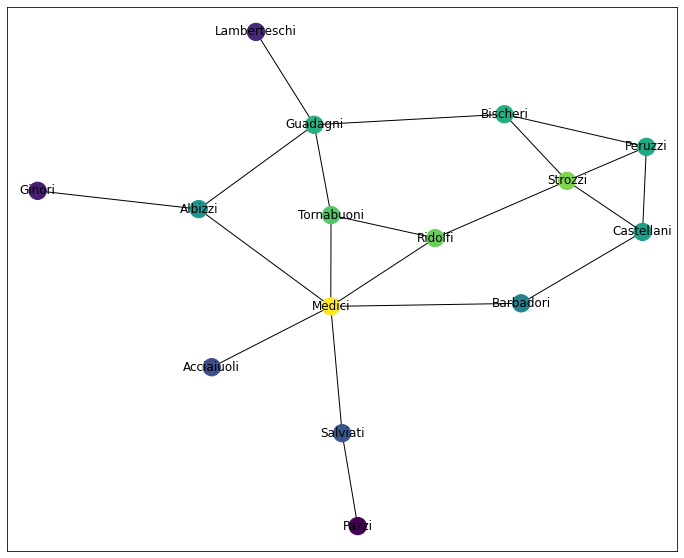

In [ ]:
draw_network_plot(G, ec)

### Page Rank

Like Eigenvector Centrality, PageRank is a *recursively defined* Centrality Measure that considers the scores of a node's neighbors in the score calculation for a given node. But whereas Eigenvector Centrality is a plug-and-chug calculation of the adjacency matrix, PageRank employs a more tangible algorithm.

All told, a node's PageRank score (loosely) represents "the probability that a person randomly traversing edges will arrive at the node." We say 'probability' because there's an element of chance at play here.

Let's back up.

PageRank is an algorithm that works *exclusively* on **Directed** graphs. When we pass in an *undirected* graph-- like the one we've been working with thus far-- under the hood, we re-cast this as a Directed Graph with twice as many edges (one for each direction). Then, we re-weight each edge such that all of the weights add to 1 (we can bias the starting condition, but let's ignore that for now).

Then `networkx` pipes this DiGraph into a Stochastic Graph object, which essentially uses the edge weights to simulate random walks through the network.

Using this, [we simulate several rounds where we](https://networkx.org/documentation/stable/_modules/networkx/algorithms/link_analysis/pagerank_alg.html#pagerank):

- Simulate random movement through the network
- Tabulate how much our data has sunk into `dangling_nodes`-- or nodes that don't have an out edge-- the more data pooling in the terminal nodes, the more *important* those terminal nodes
- Similarly, when the terminal nodes increase in value, *the nodes responsible for pushing data to them become more valueable*
- Thus, we back-propogate a big chunk of value to the penultimate nodes, a moderate chunk to the second-to-last nodes, etc, etc

This runs until the aggregate, intra-node, round-to-round movements converge to some small value and we're left with a network that's more or less stable.

The wrinkle-- and indeed, the brilliance-- to all of this, is that at each step, there's an `alpha` value (default=`.85`) that the simulated user/entity will move again after this round. Or stated in the reverse, there's a `p=.15` chance they just stop at whatever node they were at, on round `t`.

This allows for some interesting (and more-realistic) simulation of user behavior. At the two extremes:

- `alpha=1`: All actors move until they sink into a node with no way out (think long-term Markov Chain behavior). Calculate PageRank accordingly.
- `alpha=0`: There's a `p=1.00` chance that the agents don't take a single step. Page Rank will just be `1 / N` for each node.

Thus, picking the correct value for `alpha` means striking a balance that finds "realistic randomness."

But until we know what we're doing, let's stick with the default, lol

In [ ]:
pr = nx.pagerank(G)
pr = pd.Series(pr, name='pagerank')

pr.sort_values(ascending=False)

Medici          0.145818
Guadagni        0.098399
Strozzi         0.088098
Albizzi         0.079122
Tornabuoni      0.071279
Ridolfi         0.069574
Castellani      0.069330
Bischeri        0.068862
Peruzzi         0.067875
Salviati        0.061303
Barbadori       0.050301
Pazzi           0.036054
Ginori          0.032418
Lamberteschi    0.030909
Acciaiuoli      0.030657
Name: pagerank, dtype: float64

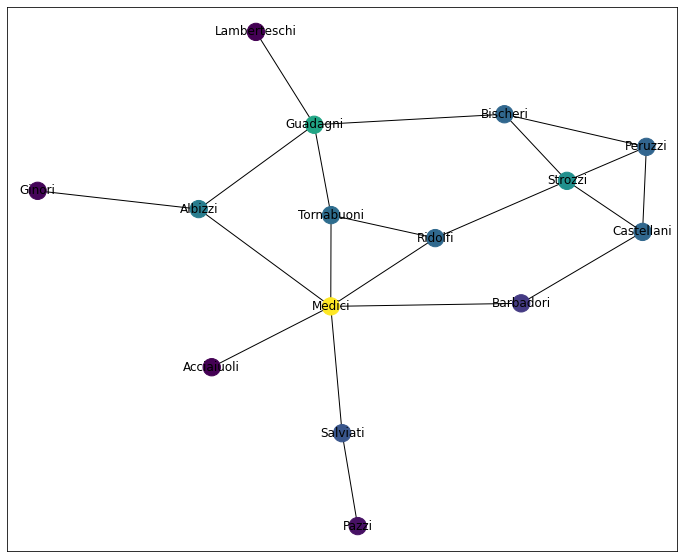

In [ ]:
draw_network_plot(G, pr)

Making a note of it here, the book mentions "HITS Hubs and Authorities" as *similar, but opposite* approaches to PageRank. Will come back and update these notes if I find that it's convincingly-different from what we've covered thus far.

In [ ]:
hits = nx.hits(G)
hits = pd.Series(hits[0], name='hits')

## So What's "Best?" 

*Whatever that means....*

For starters, let's merge all of the results into one big ol' DataFrame

In [ ]:
df = pd.concat([dc, cc, hc, ec, bc, pr, hits], axis=1)
df

,degree,closeness,harmoinic,eigenvector,betweenness,pagerank,hits
Acciaiuoli,0.071429,0.368421,0.422619,0.132157,0.000000,0.030657,0.037730
Medici,0.428571,0.560000,0.678571,0.430315,0.521978,0.145818,0.122853
Castellani,0.214286,0.388889,0.494048,0.259020,0.054945,0.069330,0.073952
Peruzzi,0.214286,0.368421,0.484524,0.275722,0.021978,0.067875,0.078721
Strozzi,0.285714,0.437500,0.559524,0.355973,0.102564,0.088098,0.101633
Barbadori,0.142857,0.437500,0.505952,0.211706,0.093407,0.050301,0.060442
Ridolfi,0.214286,0.500000,0.571429,0.341554,0.113553,0.069574,0.097514
Tornabuoni,0.214286,0.482759,0.559524,0.325847,0.091575,0.071279,0.093028
Albizzi,0.214286,0.482759,0.559524,0.243961,0.212454,0.079122,0.069650
Salviati,0.142857,0.388889,0.470238,0.145921,0.142857,0.061303,0.041659


Then we'll employ the favorite blunt instrument of any Data Scientist.

In [ ]:
df.corr()

,degree,closeness,harmoinic,eigenvector,betweenness,pagerank,hits
degree,1.000000,0.824514,0.929537,0.925372,0.844151,0.985759,0.925369
closeness,0.824514,1.000000,0.964901,0.868137,0.806630,0.824776,0.868119
harmoinic,0.929537,0.964901,1.000000,0.947494,0.821570,0.913117,0.947483
eigenvector,0.925372,0.868137,0.947494,1.000000,0.665501,0.864561,1.000000
betweenness,0.844151,0.806630,0.821570,0.665501,1.000000,0.913238,0.665479
pagerank,0.985759,0.824776,0.913117,0.864561,0.913238,1.000000,0.864552
hits,0.925369,0.868119,0.947483,1.000000,0.665479,0.864552,1.000000


And I'm told if you stare at this long enough, you might intuit that these measures fall, broadly, into two classes:

- Group A: ['Eigenvector', 'Harmonic', 'PageRank']
- Group B:
    - Subgroup I: ['Degree', 'Betweenness']
    - Subgroup II: ['Closeness', 'HITS']
    
He then goes on to say (emphasis mine-- words entirely his, please don't DMCA me)

>I am *almost* saying that knowing one representative measure from each group-- say, closeness, betweeness, and eigenvector centralities-- *probably* will suffice for all practical purposes. **But the final choice is yours.**

Like HITS, I'll come back and update this section if this understanding winds up biting me in the ass.

## Reflections

In this chapter, we defined a metric of node importance: the degree centrality metric.
In the example we looked at, it could help us identify
potential infectious agent superspreaders in a disease contact network.
In other settings, it might help us spot:

- message amplifiers/influencers in a social network, and 
- potentially crowded airports that have lots of connections into and out of it (still relevant to infectious disease spread!)
- and many more!

What other settings can you think of in which the number of neighbors that a node has can become
a metric of importance for the node?

In [72]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [73]:
G0 = nx.Graph()
list_edges = [('a', 'd'), ('d', 'i'), ('g', 'h'), ('f', 'h'), ('b', 'e'), 
              ('c', 'e'), ('e', 'i'), ('h', 'j'), ('j', 'n'), ('h', 'i'),
              ('i', 'l'), ('l', 'n'), ('n', 'o'), ('l', 'o'), ('l', 'k'), 
              ('k', 'n'), ('o', 'k'), ('k', 'u'), ('m', 'u'), ('l', 'm'), 
              ('o', 'p'), ('k', 'p'), ('k', 's'), ('u', 's'), ('s', 'r'), 
              ('s', 'q'), ('s', 'p'), ('s', 'n'), ('s', 'o')]
G0.add_edges_from(list_edges)

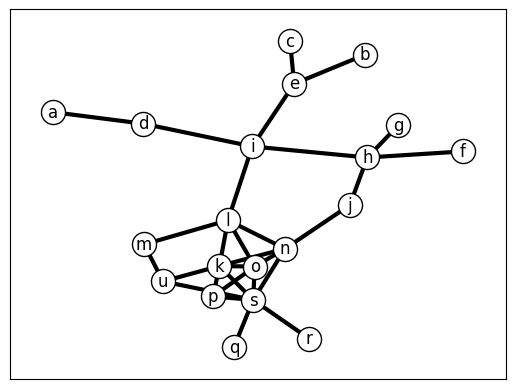

In [59]:
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 3,
}
nx.draw_networkx(G0, **options)

In [56]:
layout_dict = dict()

def draw_network_plot(graph, color_dict=None):
    global layout_dict
    
    if graph.name not in layout_dict:
        layout_dict[graph.name] = nx.spring_layout(graph)
        
    layout = layout_dict[graph.name]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    nx.draw_networkx(graph, ax=ax, node_color=color_dict, pos=layout)
    
    
as_series = lambda x: pd.Series(dict(x)).sort_values(ascending=False)

In [63]:
dc = nx.degree_centrality(G0)
dc = pd.Series(dc, name='degree')
dc.sort_values(ascending=False)

s    0.368421
k    0.315789
n    0.263158
l    0.263158
o    0.263158
i    0.210526
h    0.210526
u    0.157895
p    0.157895
e    0.157895
m    0.105263
j    0.105263
d    0.105263
r    0.052632
a    0.052632
c    0.052632
b    0.052632
f    0.052632
g    0.052632
q    0.052632
Name: degree, dtype: float64

In [74]:
cc = nx.closeness_centrality(G0)
cc = pd.Series(cc, name='closeness')
cc.sort_values(ascending=False)


l    0.475000
i    0.463415
n    0.441860
k    0.422222
o    0.413043
h    0.387755
j    0.387755
s    0.380000
m    0.358491
e    0.345455
d    0.333333
u    0.327586
p    0.322034
g    0.283582
f    0.283582
r    0.279412
q    0.279412
c    0.260274
b    0.260274
a    0.253333
Name: closeness, dtype: float64

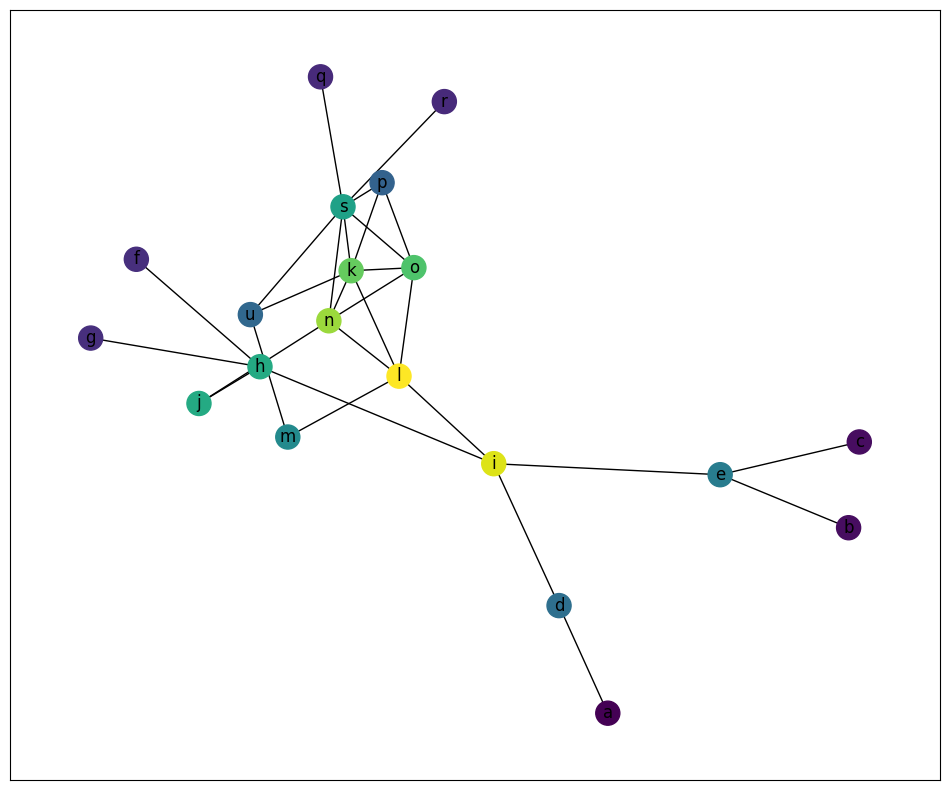

In [65]:
draw_network_plot(G0, cc)


In [67]:
bc = nx.betweenness_centrality(G0, normalized=True)
bc = pd.Series(bc, name='betweenness')
bc.sort_values(ascending=False)

i    0.512865
l    0.390058
h    0.239766
s    0.229630
e    0.204678
n    0.183041
k    0.116179
j    0.107018
d    0.105263
o    0.073782
m    0.024854
u    0.023392
r    0.000000
p    0.000000
a    0.000000
c    0.000000
b    0.000000
f    0.000000
g    0.000000
q    0.000000
Name: betweenness, dtype: float64

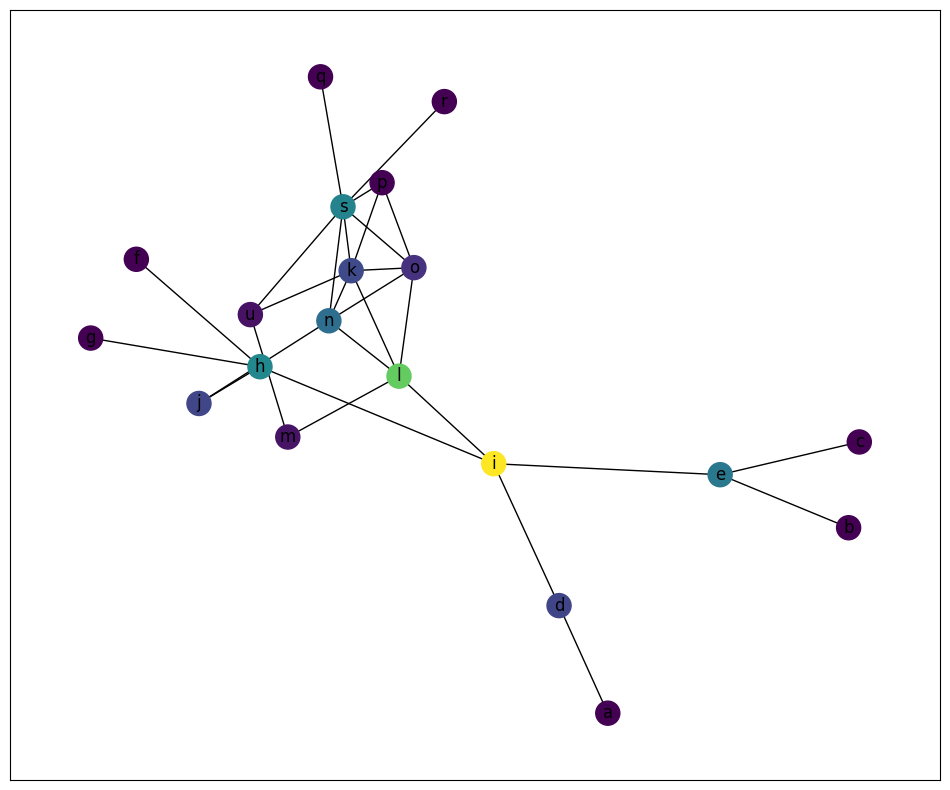

In [69]:
draw_network_plot(G0, bc)


In [70]:
ec = nx.eigenvector_centrality(G0)
ec = pd.Series(ec, name='eigenvector')
ec.sort_values(ascending=False)


k    0.455341
s    0.431357
o    0.415031
n    0.379961
l    0.323184
p    0.287741
u    0.222672
m    0.120659
r    0.095349
q    0.095349
j    0.094013
i    0.091075
h    0.045346
e    0.022313
d    0.021167
f    0.010024
g    0.010024
c    0.004933
b    0.004933
a    0.004679
Name: eigenvector, dtype: float64

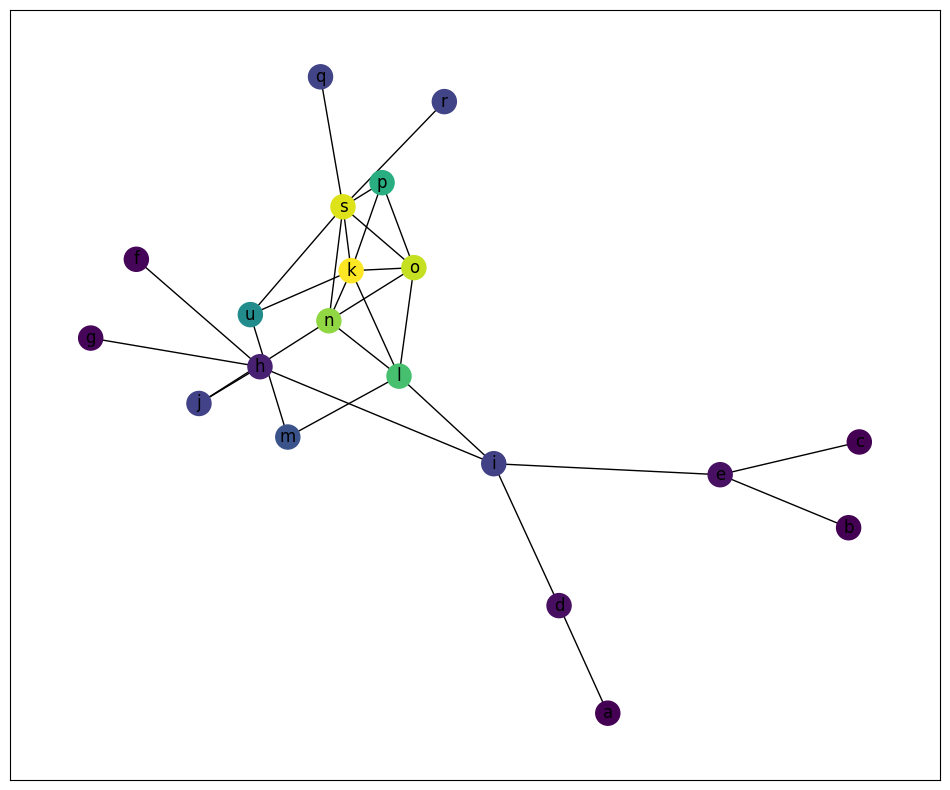

In [71]:

draw_network_plot(G0, ec)

## Introduction to Paths

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="JjpbztqP9_0", width="100%")

### Example of Paths

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
G = nx.Graph()

In [ ]:
nodes_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
G.add_nodes_from(nodes_list)

In [ ]:
edges_list = [('a', 'e'), ('e', 'd'), ('d', 'f'), ('e', 'f'), ('f', 'h'), ('h', 'b'), ('h', 'i'), ('f', 'g')]
G.add_edges_from(edges_list)

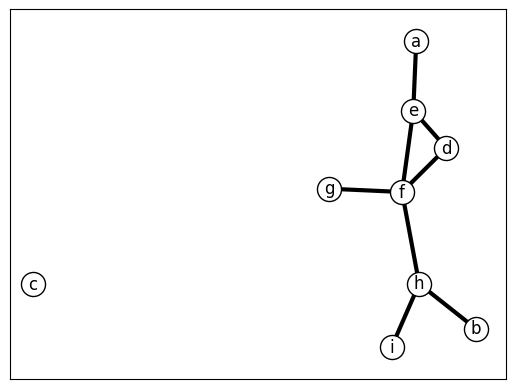

In [ ]:
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 3,
}
nx.draw_networkx(G, **options)

In [ ]:
nx.has_path(G, 'a', 'i') 			# False

True

In [ ]:
nx.has_path(G, 'a', 'b') 			# True

True

In [ ]:
nx.shortest_path(G, 'a', 'b') 		# ['a', 'e', 'f', 'h', 'b']

['a', 'e', 'f', 'h', 'b']

In [ ]:
nx.shortest_path_length(G, 'a', 'b') # 4 

4

In [ ]:
nx.shortest_path(G, 'a')				# dictionary

{'a': ['a'],
 'e': ['a', 'e'],
 'd': ['a', 'e', 'd'],
 'f': ['a', 'e', 'f'],
 'h': ['a', 'e', 'f', 'h'],
 'g': ['a', 'e', 'f', 'g'],
 'b': ['a', 'e', 'f', 'h', 'b'],
 'i': ['a', 'e', 'f', 'h', 'i']}

In [ ]:
nx.shortest_path_length(G, 'a')		# dictionary

{'a': 0, 'e': 1, 'd': 2, 'f': 2, 'h': 3, 'g': 3, 'b': 4, 'i': 4}

In [ ]:
nx.shortest_path(G)					# all pairs

{'a': {'a': ['a'],
  'e': ['a', 'e'],
  'd': ['a', 'e', 'd'],
  'f': ['a', 'e', 'f'],
  'h': ['a', 'e', 'f', 'h'],
  'g': ['a', 'e', 'f', 'g'],
  'b': ['a', 'e', 'f', 'h', 'b'],
  'i': ['a', 'e', 'f', 'h', 'i']},
 'b': {'b': ['b'],
  'h': ['b', 'h'],
  'f': ['b', 'h', 'f'],
  'i': ['b', 'h', 'i'],
  'e': ['b', 'h', 'f', 'e'],
  'g': ['b', 'h', 'f', 'g'],
  'd': ['b', 'h', 'f', 'd'],
  'a': ['b', 'h', 'f', 'e', 'a']},
 'c': {'c': ['c']},
 'd': {'d': ['d'],
  'e': ['d', 'e'],
  'f': ['d', 'f'],
  'a': ['d', 'e', 'a'],
  'h': ['d', 'f', 'h'],
  'g': ['d', 'f', 'g'],
  'b': ['d', 'f', 'h', 'b'],
  'i': ['d', 'f', 'h', 'i']},
 'e': {'e': ['e'],
  'a': ['e', 'a'],
  'd': ['e', 'd'],
  'f': ['e', 'f'],
  'h': ['e', 'f', 'h'],
  'g': ['e', 'f', 'g'],
  'b': ['e', 'f', 'h', 'b'],
  'i': ['e', 'f', 'h', 'i']},
 'f': {'f': ['f'],
  'e': ['f', 'e'],
  'h': ['f', 'h'],
  'g': ['f', 'g'],
  'd': ['f', 'd'],
  'a': ['f', 'e', 'a'],
  'b': ['f', 'h', 'b'],
  'i': ['f', 'h', 'i']},
 'g': {'g': ['g'],
 

In [ ]:
nx.shortest_path_length(G)			# all pairs

<generator object all_pairs_shortest_path_length at 0x7f30c15402e0>

In [ ]:
dict(nx.shortest_path_length(G))

{'a': {'a': 0, 'e': 1, 'd': 2, 'f': 2, 'h': 3, 'g': 3, 'b': 4, 'i': 4},
 'b': {'b': 0, 'h': 1, 'f': 2, 'i': 2, 'd': 3, 'e': 3, 'g': 3, 'a': 4},
 'c': {'c': 0},
 'd': {'d': 0, 'e': 1, 'f': 1, 'a': 2, 'h': 2, 'g': 2, 'b': 3, 'i': 3},
 'e': {'e': 0, 'a': 1, 'd': 1, 'f': 1, 'h': 2, 'g': 2, 'b': 3, 'i': 3},
 'f': {'f': 0, 'd': 1, 'e': 1, 'h': 1, 'g': 1, 'a': 2, 'b': 2, 'i': 2},
 'g': {'g': 0, 'f': 1, 'd': 2, 'e': 2, 'h': 2, 'a': 3, 'b': 3, 'i': 3},
 'h': {'h': 0, 'f': 1, 'b': 1, 'i': 1, 'd': 2, 'e': 2, 'g': 2, 'a': 3},
 'i': {'i': 0, 'h': 1, 'f': 2, 'b': 2, 'd': 3, 'e': 3, 'g': 3, 'a': 4}}

In [ ]:
nx.average_shortest_path_length(G) 	# error

NetworkXError: ignored

In [ ]:
G.remove_node('c')					# G is fully connected

In [ ]:
nx.average_shortest_path_length(G)

2.142857142857143

In [ ]:
list(nx.connected_components(G))

[{'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i'}]

Graph traversal is akin to walking along the graph, node by node,
constrained by the edges that connect the nodes.
Graph traversal is particularly useful for understanding 
the local structure of certain portions of the graph
and for finding paths that connect two nodes in the network.

In this chapter, we are going to learn how to perform pathfinding in a graph,
specifically by looking for _shortest paths_ via the _breadth-first search_ algorithm.

## Breadth-First Search

The BFS algorithm is a staple of computer science curricula,
and for good reason:
it teaches learners how to "think on" a graph,
putting one in the position of 
"the dumb computer" that can't use a visual cortex to 
"_just know_" how to trace a path from one node to another.
As a topic, learning how to do BFS
additionally imparts algorithmic thinking to the learner.

### Exercise: Design the algorithm

Try out this exercise to get some practice with algorithmic thinking.

> 1. On a piece of paper, conjure up a graph that has 15-20 nodes. Connect them any way you like.
> 1. Pick two nodes. Pretend that you're standing on one of the nodes, but you can't see any further beyond one neighbor away.
> 1. Work out how you can find _a_ path from the node you're standing on to the other node, given that you can _only_ see nodes that are one neighbor away but have an infinitely good memory.

If you are successful at designing the algorithm, you should get the answer below.

In [ ]:
df = pd.read_csv(
       "https://raw.githubusercontent.com/ericmjl/Network-Analysis-Made-Simple/master/data/sociopatterns-infectious/out.sociopatterns-infectious",
        sep=" ",
        skiprows=2,
        header=None,
    )
df = df[[0, 1, 2]]
df.columns = ["person1", "person2", "weight"]

G = nx.Graph()
for row in df.iterrows():
    p1 = row[1]["person1"]
    p2 = row[1]["person2"]
    if G.has_edge(p1, p2):
        G.edges[p1, p2]["weight"] += 1
    else:
        G.add_edge(p1, p2, weight=1)

for n in sorted(G.nodes()):
    G.nodes[n]["order"] = float(n)

In [ ]:
#@title
from markdown import Markdown
from IPython.display import HTML

def bfs_algorithm():
    """
    How to design a BFS algorithm.
    """
    ans = """
How does the breadth-first search work?
It essentially is as follows:

1. Begin with a queue that has only one element in it: the starting node.
2. Add the neighbors of that node to the queue.
    1. If destination node is present in the queue, end.
    2. If destination node is not present, proceed.
3. For each node in the queue:
    1. Remove node from the queue.
    2. Add neighbors of the node to the queue. Check if destination node is present or not.
    3. If destination node is present, end. <!--Credit: @cavaunpeu for finding bug in pseudocode.-->
    4. If destination node is not present, continue.
"""
    md = Markdown()
    return HTML(md.convert(ans))

In [ ]:
#@title
bfs_algorithm()

### Exercise: Implement the algorithm

> Now that you've seen how the algorithm works, try implementing it!

In [ ]:
# FILL IN THE BLANKS BELOW

def path_exists(node1, node2, G):
    """
    This function checks whether a path exists between two nodes (node1, 
    node2) in graph G.
    """
    visited_nodes = _____
    queue = [_____]
    
    while len(queue) > 0:
        node = ___________
        neighbors = list(_________________)
        if _____ in _________:
            # print('Path exists between nodes {0} and {1}'.format(node1, node2))
            return True
        else:
            visited_nodes.___(____)
            nbrs = [_ for _ in _________ if _ not in _____________]
            queue = ____ + _____
    
    # print('Path does not exist between nodes {0} and {1}'.format(node1, node2))
    return False


In [ ]:
#@title
def path_exists(node1, node2, G):
    """
    This function checks whether a path exists between two nodes (node1,
    node2) in graph G.
    """

    visited_nodes = set()
    queue = [node1]

    while len(queue) > 0:
        node = queue.pop()
        neighbors = list(G.neighbors(node))
        if node2 in neighbors:
            return True
        else:
            visited_nodes.add(node)
            nbrs = [n for n in neighbors if n not in visited_nodes]
            queue = nbrs + queue

    return False


In [ ]:
# Define path_exists()
def path_exists(G, node1, node2):
    """
    This function checks whether a path exists between two nodes (node1, node2) in graph G.
    """
    visited_nodes = set()

    # Initialize the queue of nodes to visit with the first node: queue
    queue = [node1]

    # Iterate over the nodes in the queue
    for node in queue:

        # Get neighbors of the node
        neighbors = list(G.neighbors(node))

        # Check to see if the destination node is in the set of neighbors
        if node2 in neighbors:
            print('Path exists between nodes {0} and {1}'.format(node1, node2))
            return True
            break
        else:
            visited_nodes.add(node)
            nbrs = [n for n in neighbors if n not in visited_nodes]
            queue = nbrs + queue
    return False

In [ ]:
# CHECK YOUR ANSWER AGAINST THE TEST FUNCTION BELOW
from random import sample
import networkx as nx


def test_path_exists(N):
    """
    N: The number of times to spot-check.
    """
    for i in range(N):
        n1, n2 = sample(G.nodes(), 2)
        assert path_exists(n1, n2, G) == bool(nx.shortest_path(G, n1, n2))
    return True
    
assert test_path_exists(10)

## Visualizing Paths

One of the objectives of that exercise before was to help you "think on graphs".
Now that you've learned how to do so, you might be wondering,
"How do I visualize that path through the graph?"

Well first off, if you inspect the `test_path_exists` function above,
you'll notice that NetworkX provides a `shortest_path()` function
that you can use. Here's what using `nx.shortest_path()` looks like.

In [ ]:
path = nx.shortest_path(G, 7, 400)
path

As you can see, it returns the nodes along the shortest path,
incidentally in the exact order that you would traverse.

One thing to note, though!
If there are multiple shortest paths from one node to another,
NetworkX will only return one of them.

So how do you draw those nodes _only_?

You can use the `G.subgraph(nodes)`
to return a new graph that only has nodes in `nodes`
and only the edges that exist between them.
After that, you can use any plotting library you like.
We will show an example here that uses nxviz's matrix plot.

Let's see it in action:

In [ ]:
import nxviz as nv
g = G.subgraph(path)
nv.matrix(g, sort_by="order")

_Voila!_ Now we have the subgraph (1) extracted and (2) drawn to screen!
In this case, the matrix plot is a suitable visualization for its compactness.
The off-diagonals also show that each node is a neighbor to the next one.

You'll also notice that if you try to modify the graph `g`, say by adding a node:

```python
g.add_node(2048)
```

you will get an error:

```python
---------------------------------------------------------------------------
NetworkXError                             Traceback (most recent call last)
<ipython-input-10-ca6aa4c26819> in <module>
----> 1 g.add_node(2048)

~/anaconda/envs/nams/lib/python3.7/site-packages/networkx/classes/function.py in frozen(*args, **kwargs)
    156 def frozen(*args, **kwargs):
    157     """Dummy method for raising errors when trying to modify frozen graphs"""
--> 158     raise nx.NetworkXError("Frozen graph can't be modified")
    159 
    160 

NetworkXError: Frozen graph can't be modified
```

From the perspective of semantics, this makes a ton of sense:
the subgraph `g` is a perfect subset of the larger graph `G`,
and should not be allowed to be modified
unless the larger container graph is modified.

### Exercise: Draw path with neighbors one degree out

Try out this next exercise:

> Extend graph drawing with the neighbors of each of those nodes.
> Use any of the nxviz plots (`nv.matrix`, `nv.arc`, `nv.circos`);
> try to see which one helps you tell the best story.

In [ ]:
### YOUR SOLUTION BELOW


In [ ]:
#@title
import nxviz as nv
from nxviz import annotate, highlights

def plot_path_with_neighbors(G, n1, n2):
    """Plot a path with the heighbors of of the nodes along that path."""
    path = nx.shortest_path(G, n1, n2)
    nodes = [*path]
    for node in path:
        nodes.extend(list(G.neighbors(node)))
    nodes = list(set(nodes))

    g = G.subgraph(nodes)
    nv.arc(
        g, sort_by="order", node_color_by="order", edge_enc_kwargs={"alpha_scale": 0.5}
    )
    for n in path:
        highlights.arc_node(g, n, sort_by="order")
    for n1, n2 in zip(path[:-1], path[1:]):
        highlights.arc_edge(g, n1, n2, sort_by="order")

In [ ]:
plot_path_with_neighbors(G, 7, 400)

In this case, we opted for an Arc plot because we only have one grouping of nodes but have a logical way to order them.
Because the path follows the order, the edges being highlighted automatically look like hops through the graph.

## Bottleneck nodes

We're now going to revisit the concept of an "important node",
this time now leveraging what we know about paths.

In the "hubs" chapter, we saw how a node that is "important"
could be so because it is connected to many other nodes.

Paths give us an alternative definition.
If we imagine that we have to pass a message on a graph
from one node to another,
then there may be "bottleneck" nodes
for which if they are removed,
then messages have a harder time flowing through the graph.

One metric that measures this form of importance
is the "betweenness centrality" metric.
On a graph through which a generic "message" is flowing,
a node with a high betweenness centrality
is one that has a high proportion of shortest paths
flowing through it.
In other words, it behaves like a _bottleneck_.

### Betweenness centrality in NetworkX

NetworkX provides a "betweenness centrality" function
that behaves consistently with the "degree centrality" function,
in that it returns a mapping from node to metric:

In [ ]:
import pandas as pd

pd.Series(nx.betweenness_centrality(G))

### Exercise: compare degree and betweenness centrality

> Make a scatterplot of degree centrality on the x-axis
> and betweenness centrality on the y-axis.
> Do they correlate with one another?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# YOUR ANSWER HERE:


In [ ]:
#@title
def plot_degree_betweenness(G):
    """Plot scatterplot between degree and betweenness centrality."""
    bc = pd.Series(nx.betweenness_centrality(G))
    dc = pd.Series(nx.degree_centrality(G))

    df = pd.DataFrame(dict(bc=bc, dc=dc))
    ax = df.plot(x="dc", y="bc", kind="scatter")
    ax.set_ylabel("Betweenness\nCentrality")
    ax.set_xlabel("Degree Centrality")
    sns.despine()

In [ ]:
plot_degree_betweenness(G)

### Think about it...

...does it make sense that degree centrality and betweenness centrality
are not well-correlated?

Can you think of a scenario where a node has a
"high" betweenness centrality
but a "low" degree centrality?
Before peeking at the graph below,
think about your answer for a moment.

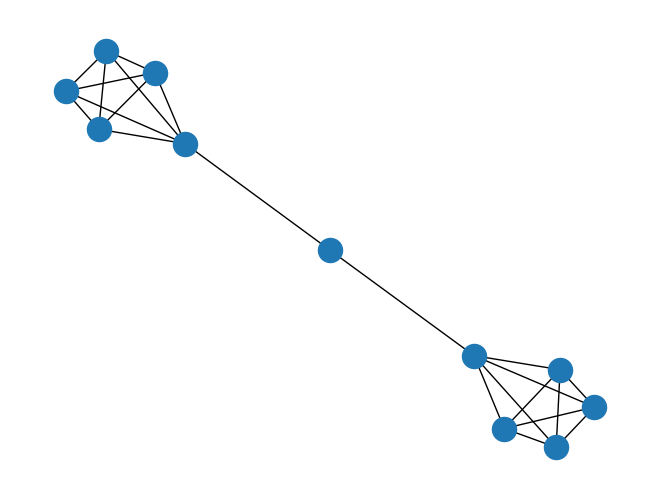

In [ ]:
nx.draw(nx.barbell_graph(5, 1))

## Recap

In this chapter, you learned the following things:

1. You figured out how to implement the breadth-first-search algorithm to find shortest paths.
1. You learned how to extract subgraphs from a larger graph.
1. You implemented visualizations of subgraphs, which should help you as you communicate with colleagues.
1. You calculated betweenness centrality metrics for a graph, and visualized how they correlated with degree centrality.

## Introduction to Structures


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="3DWSRCbPPJs", width="100%")

If you remember, at the beginning of this book,
we saw a quote from John Quackenbush that essentially said
that the reason a graph is interesting is because of its edges.
In this chapter, we'll see this in action once again,
as we are going to figure out how to leverage the edges
to find special _structures_ in a graph.

## Triangles

The first structure that we are going to learn about is **triangles**.
Triangles are super interesting!
They are what one might consider to be
"the simplest complex structure" in a graph.
Triangles can also have semantically-rich meaning depending on the application.
To borrow a bad example, love triangles in social networks are generally frowned upon,
while on the other hand, when we connect two people that we know together,
we instead _complete_ a triangle.

### Load Data

To learn about triangles,
we are going to leverage a physician trust network.
Here's the data description:

> This directed network captures innovation spread among 246 physicians 
> for towns in Illinois, Peoria, Bloomington, Quincy and Galesburg.
> The data was collected in 1966.
> A node represents a physician and an edge between two physicians
> shows that the left physician told that the right physician is his friend
> or that he turns to the right physician if he needs advice
> or is interested in a discussion.
> There always only exists one edge between two nodes
> even if more than one of the listed conditions are true.

In [ ]:
df = pd.read_csv(
        "https://raw.githubusercontent.com/ericmjl/Network-Analysis-Made-Simple/master/data/moreno_innovation/out.moreno_innovation_innovation",
        sep=" ",
        skiprows=2,
        header=None,
  )
df = df[[0, 1]]
df.columns = ["doctor1", "doctor2"]

G = nx.Graph()
for row in df.iterrows():
    G.add_edge(row[1]["doctor1"], row[1]["doctor2"])

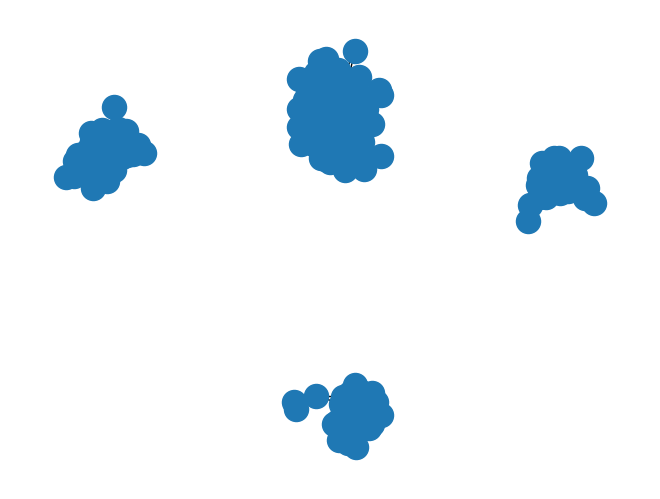

In [ ]:
nx.draw(G)
plt.show()

### Exercise: Finding triangles in a graph

This exercise is going to flex your ability
to "think on a graph", just as you did in the previous chapters.

> Leveraging what you know, can you think of a few strategies
> to find triangles in a graph?

In [ ]:
##

### Exercise: Identify whether a node is in a triangle relationship or not

Let's now get down to implementing this next piece of code.

> Write a function that identifies whether a node is or is not in a triangle relationship.
> It should take in a graph `G` and a node `n`,
> and return a boolean True if the node `n` is in any triangle relationship
> and boolean False if the node `n` is not in any triangle relationship.

A hint that may help you:

> Every graph object `G` has a `G.has_edge(n1, n2)` method that you can use to identify whether a graph has an edge between `n1` and `n2`.

Also:

> `itertools.combinations` lets you iterate over every _K-combination_ of items in an iterable.

In [ ]:

def in_triangle(G, node):
    # Your answer here
    pass


Now, test your implementation below!
The code cell will not error out if your answer is correct.

In [ ]:
from random import sample
import networkx as nx

def test_in_triangle():
    nodes = sample(G.nodes(), 10)
    for node in nodes:
        assert in_triangle(G, 3) == bool(nx.triangles(G, 3))
        
test_in_triangle()

As you can see from the test function above,
NetworkX provides an `nx.triangles(G, node)` function.
It returns the number of triangles that a node is involved in.
We convert it to boolean as a hack to check whether or not
a node is involved in a triangle relationship
because 0 is equivalent to boolean `False`,
while any non-zero number is equivalent to boolean `True`.

### Exercise: Extract triangles for plotting

We're going to leverage another piece of knowledge that you already have:
the ability to extract subgraphs.
We'll be plotting all of the triangles that a node is involved in.

> Given a node, write a function that extracts out
> all of the neighbors that it is in a triangle relationship with.
> Then, in a new function,
> implement code that plots only the subgraph
> that contains those nodes.

In [ ]:
def get_triangle_neighbors(G, n):
    # Your answer here
    pass



In [ ]:
def plot_triangle_relations(G, n):
    # Your answer here
    pass



## Triadic Closure

In professional circles, making connections between two people
is one of the most valuable things you can do professionally.
What you do in that moment is what we would call
**triadic closure**.
Algorithmically, we can do the same thing
if we maintain a graph of connections!

Essentially, what we are looking for
are "open" or "unfinished" triangles".

In this section, we'll try our hand at implementing
a rudimentary triadic closure system.

### Exercise: Design the algorithm

> What graph logic would you use to identify triadic closure opportunities?
> Try writing out your general strategy, or discuss it with someone.

In [ ]:
##

### Exercise: Implement triadic closure.

Now, try your hand at implementing triadic closure.

> Write a function that takes in a graph `G` and a node `n`,
> and returns all of the neighbors that are potential triadic closures
> with `n` being the center node.


In [ ]:
def get_open_triangles_neighbors(G, n):
    # Your answer here
    pass


### Exercise: Plot the open triangles

> Now, write a function that takes in a graph `G` and a node `n`,
> and plots out that node `n` and all of the neighbors
> that it could help close triangles with.


In [ ]:
def plot_open_triangle_relations(G, n):
    # Your answer here
    pass


## Cliques

Triangles are interesting in a graph theoretic setting
because triangles are the simplest complex clique that exist.

But wait!
What is the definition of a "clique"?

> A "clique" is a set of nodes in a graph
> that are fully connected with one another
> by edges between them.

### Exercise: Simplest cliques

Given this definition, what is the simplest "clique" possible?

In [ ]:
#

### $k$-Cliques

Cliques are identified by their size $k$,
which is the number of nodes that are present in the clique.

A triangle is what we would consider to be a $k$-clique where $k=3$.

A square with cross-diagonal connections is what we would consider to be
a $k$-clique where $k=4$.

By now, you should get the gist of the idea.

### Maximal Cliques

Related to this idea of a $k$-clique is another idea called "maximal cliques".

Maximal cliques are defined as follows:

> A maximal clique is a subgraph of nodes in a graph
> 
> 1. to which no other node can be added to it and 
> 2. still remain a clique.

NetworkX provides a way to find all maximal cliques:

In [ ]:
# I have truncated the output to the first 5 maximal cliques.
list(nx.find_cliques(G))[0:5]

### Exercise: finding sized-$k$ maximal cliques

> Write a generator function that yields all maximal cliques of size $k$.

I'm requesting a generator as a matter of good practice;
you never know when the list you return might explode in memory consumption,
so generators are a cheap and easy way to reduce memory usage.

In [ ]:
def size_k_maximal_cliques(G, k):
    # Your answer here
    pass


Now, test your implementation against the test function below.

In [ ]:
def test_size_k_maximal_cliques(G, k):
    clique_generator = size_k_maximal_cliques(G, k)
    for clique in clique_generator:
        assert len(clique) == k
    
test_size_k_maximal_cliques(G, 5)

### Clique Decomposition

One _super_ neat property of cliques
is that every clique of size $k$
can be decomposed to the set of cliques of size $k-1$.

Does this make sense to you?
If not, think about triangles (3-cliques).
They can be decomposed to three edges (2-cliques).

Think again about 4-cliques.
Housed within 4-cliques are four 3-cliques.
_Draw it out if you're still not convinced!_

### Exercise: finding all $k$-cliques in a graph

> Knowing this property of $k$-cliques,
> write a generator function that yields all $k$-cliques in a graph,
> leveraging the `nx.find_cliques(G)` function.

Some hints to help you along:

> If a $k$-clique can be decomposed to its $k-1$ cliques,
> it follows that the $k-1$ cliques can be decomposed into $k-2$ cliques,
> and so on until you hit 2-cliques.
> This implies that all cliques of size $k$
> house cliques of size $n < k$, where $n >= 2$.

In [ ]:
def find_k_cliques(G, k):
    # your answer here
    pass


## Connected Components

Now that we've explored a lot around cliques,
we're now going to explore this idea of "connected components".
To do so, I am going to have you draw the graph
that we are working with.


In [ ]:
import nxviz as nv

nv.circos(G)

### Exercise: Visual insights

From this rendering of the CircosPlot,
what visual insights do you have about the structure of the graph?

In [ ]:
## 

### Defining connected components

From [Wikipedia](https://en.wikipedia.org/wiki/Connected_component_%28graph_theory%29):

> In graph theory, a connected component (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph.

NetworkX provides a function to let us find all of the connected components:

In [ ]:
ccsubgraph_nodes = list(nx.connected_components(G))

Let's see how many connected component subgraphs are present:

In [ ]:
len(ccsubgraph_nodes)

### Example of Connected Components

In [ ]:
import networkx as nx
G2 = nx.DiGraph()

In [ ]:
nodes_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
G2.add_nodes_from(nodes_list)

In [ ]:
edges_list = [('a', 'e'), ('e', 'd'), ('d', 'f'), ('f', 'e'), ('f', 'h'), ('h', 'b'), ('i', 'h'), ('f', 'g')]
G2.add_edges_from(edges_list)

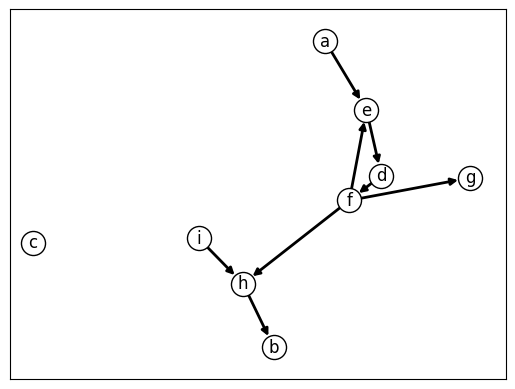

In [ ]:
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 2,
}
nx.draw_networkx(G2, **options)

In [ ]:
nx.is_strongly_connected(G2)

False

In [ ]:
nx.is_weakly_connected(G2)

False

In [ ]:
list(nx.weakly_connected_components(G2))

[{'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i'}, {'c'}]

In [ ]:
list(nx.strongly_connected_components(G2))

[{'b'}, {'h'}, {'g'}, {'d', 'e', 'f'}, {'a'}, {'c'}, {'i'}]

In [ ]:
nx.number_strongly_connected_components(G2)

7

## Connected Components

In [ ]:
# G is connected?
nx.is_connected(G2) # False

In [ ]:
for component in nx.connected_components(G2):
	print(component)


In [ ]:
nx.number_connected_components(G2)

In [ ]:
nx.node_connected_component(G2, 'a')

{'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i'}

### Exercise: visualizing connected component subgraphs

In this exercise, we're going to draw a circos plot of the graph, 
but colour and order the nodes by their connected component subgraph.

Recall Circos API:

```python
c = CircosPlot(G, node_order='node_attribute', node_color='node_attribute')
c.draw()
plt.show()  # or plt.savefig(...)
```

Follow the steps along here to accomplish this.

> Firstly, label the nodes with a unique identifier for connected component subgraph
> that it resides in.
> Use `subgraph` to store this piece of metadata.

In [ ]:
def label_connected_component_subgraphs(G):
    # Your answer here
    return G



> Now, draw a CircosPlot with the node order and colouring
> dictated by the `subgraph` key.

In [ ]:
def plot_cc_subgraph(G):
    # Your answer here
    pass


Using an arc plot will also clearly illuminate for us
that there are no inter-group connections.

In [ ]:
nv.arc(G_labelled, group_by="subgraph", node_color_by="subgraph")
annotate.arc_group(G_labelled, group_by="subgraph", rotation=0)

_Voila!_ It looks quite clear that there are indeed four disjoint group of physicians.